# Vamos a adquirir y preparar los datos de las tres fuentes que tenemos:
### 1.- Nº de manchas solares (Spots)
### 2.- Llamaradas solares (Flares)
### 3.- Eyecciones de masa coronal (CMEs)

In [1]:
# Importaciones necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style = 'whitegrid')
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None
from sklearn.model_selection import train_test_split

# Spots

In [4]:
# Echemos un vistazo al fichero
!cat "../../TFM/Datos/SN_d_tot_V2.0.csv" | head

1818;01;01;1818.001;  -1; -1.0;   0;1
1818;01;02;1818.004;  -1; -1.0;   0;1
1818;01;03;1818.007;  -1; -1.0;   0;1
1818;01;04;1818.010;  -1; -1.0;   0;1
1818;01;05;1818.012;  -1; -1.0;   0;1
1818;01;06;1818.015;  -1; -1.0;   0;1
1818;01;07;1818.018;  -1; -1.0;   0;1
1818;01;08;1818.021;  65; 10.2;   1;1
1818;01;09;1818.023;  -1; -1.0;   0;1
1818;01;10;1818.026;  -1; -1.0;   0;1
cat: write error: Broken pipe


In [5]:
# Con la descripción de los datos que tenemos (ver "SN_d_tot_V2.0_description.txt") y 
# sabiendo que los NaN se coresponden con el valor -1 (y que también tenemos 0) podemos ya cargarlo:
columns = ['Year', 'Month', 'Day', 'Fraction', 'Spots', 'Stdev', 'Observ', 'Def/Prov']
df = pd.read_csv('../../TFM/Datos/SN_d_tot_V2.0.csv', sep = ';', header = None, names = columns, na_values = [0, -1])
df

,Year,Month,Day,Fraction,Spots,Stdev,Observ,Def/Prov
0,1818,1,1,1818.001,-1,NaN,0,1.0
1,1818,1,2,1818.004,-1,NaN,0,1.0
2,1818,1,3,1818.007,-1,NaN,0,1.0
3,1818,1,4,1818.010,-1,NaN,0,1.0
4,1818,1,5,1818.012,-1,NaN,0,1.0
...,...,...,...,...,...,...,...,...
73834,2020,2,25,2020.152,0,NaN,25,NaN
73835,2020,2,26,2020.154,0,NaN,30,NaN
73836,2020,2,27,2020.157,0,NaN,28,NaN
73837,2020,2,28,2020.160,0,NaN,32,NaN


In [6]:
# No parece que nos haya transformado en NaN los datos de 'Spots', debe haber espacios en esa columna,
# vamos a quitarlos
columns = ['Year', 'Month', 'Day', 'Fraction', 'Spots', 'Stdev', 'Observ', 'Def/Prov']
df = pd.read_csv('../../TFM/Datos/SN_d_tot_V2.0.csv', sep = r'\s*;\s*', header = None, names = columns, na_values =[0, -1],
                engine = 'python')
df

,Year,Month,Day,Fraction,Spots,Stdev,Observ,Def/Prov
0,1818,1,1,1818.001,NaN,NaN,NaN,1.0
1,1818,1,2,1818.004,NaN,NaN,NaN,1.0
2,1818,1,3,1818.007,NaN,NaN,NaN,1.0
3,1818,1,4,1818.010,NaN,NaN,NaN,1.0
4,1818,1,5,1818.012,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...
73834,2020,2,25,2020.152,NaN,NaN,25.0,NaN
73835,2020,2,26,2020.154,NaN,NaN,30.0,NaN
73836,2020,2,27,2020.157,NaN,NaN,28.0,NaN
73837,2020,2,28,2020.160,NaN,NaN,32.0,NaN


In [7]:
# Un poco de información
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73839 entries, 0 to 73838
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Year      73839 non-null  int64  
 1   Month     73839 non-null  int64  
 2   Day       73839 non-null  int64  
 3   Fraction  73839 non-null  float64
 4   Spots     59396 non-null  float64
 5   Stdev     67975 non-null  float64
 6   Observ    70592 non-null  float64
 7   Def/Prov  73687 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 4.5 MB


In [8]:
# Borramos las fechas anteriores a 1975, puesto que no nos interesan para el trabajo posterior
df.drop(df[df['Year'] < 1975].index, inplace = True)

In [9]:
# Controlamos los NaN
df.isna().sum()

Year           0
Month          0
Day            0
Fraction       0
Spots       2270
Stdev        875
Observ         0
Def/Prov     152
dtype: int64

In [10]:
# Para evitar eliminar registros usaremos interpolación para rellenar los NaN en la columna "Spots"
df['Spots'] = df['Spots'].interpolate()

In [11]:
# Creamos una columna en formato fecha para operaciones posteriores
df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])

In [12]:
# Tomaremos como outliers más o menos la media + 3*(Stdev) (~325)
len(df[df['Spots'] > 325])

114

In [13]:
# Los borramos
df.drop(df[df['Spots'] > 325].index, inplace = True)

In [14]:
# Solo nos interesan la nueva columna de fecha y el número de manchas (Spots). Eliminamos el resto
df.drop(['Year', 'Month', 'Day', 'Fraction', 'Stdev', 'Observ', 'Def/Prov'], axis = 'columns', inplace = True)

In [15]:
# Reordenamos
df = df[['Date', 'Spots']].reset_index()

In [16]:
# Lo guardamos para usarlo posteriormente
df.to_csv('../../TFM/Datos/Spots_new.csv', index = False)

# Flares

In [22]:
# En este caso nos encontramos un fichero por año, incluso algún año está "partido" en dos ficheros.
# Veamos uno de ellos
! cat "../../TFM/Datos/Flares/xray-flares_1992.txt" | head











cat: write error: Broken pipe


In [24]:
# Lo más práctico será unir todos en uno y tratar el resultado
! cat ../../TFM/Datos/Flares/*.txt > ../../TFM/Datos/flare_all.txt 

In [ ]:
# Veamos el fichero resultante
! cat ../../TFM/Datos/flare_all.txt

In [25]:
# Tiene líneas "raras", seguramente por caracteres de inicio o fin de fichero
! grep 'SELDADS' ../../TFM/Datos/flare_all.txt

SELDADS X-RAY Data for 2012-01-01
SELDADS X-RAY Data for 2012-02-01
SELDADS X-RAY Data for 2012-03-01
SELDADS X-RAY Data for 2012-04-01
SELDADS X-RAY Data for 2012-05-01
SELDADS X-RAY Data for 2012-06-01
SELDADS X-RAY Data for 2012-07-01
SELDADS X-RAY Data for 2012-08-01
SELDADS X-RAY Data for 2012-10-01
SELDADS X-RAY Data for 2012-11-01
SELDADS X-RAY Data for 2012-12-01
SELDADS X-RAY Data for 2013-01-01
SELDADS X-RAY Data for 2013-02-01
SELDADS X-RAY Data for 2013-03-01
SELDADS X-RAY Data for 2013-04-01
SELDADS X-RAY Data for 2013-05-01
SELDADS X-RAY Data for 2013-06-01
SELDADS X-RAY Data for 2013-07-01
SELDADS X-RAY Data for 2013-08-01
SELDADS X-RAY Data for 2013-09-01
SELDADS X-RAY Data for 2013-10-01
SELDADS X-RAY Data for 2013-11-01
SELDADS X-RAY Data for 2013-12-01
SELDADS X-RAY Data for 2014-01-01
SELDADS X-RAY Data for 2014-02-01
SELDADS X-RAY Data for 2014-03-01
SELDADS X-RAY Data for 2014-04-01
SELDADS X-RAY Data for 2014-05-01
SELDADS X-RAY Data for 2014-06-01
SELDADS X-RAY 

In [26]:
# Las eliminamos
! sed -i '/SELDADS/d' ../../TFM/Datos/flare_all.txt

In [27]:
# También hay otros caracteres raros
! grep '' ../../TFM/Datos/flare_all.txt





970120GO80827083308489.4E-094.2E-073.4E-04
980101GO80120013401391.9E-071.7E-068.8E-04
010101GO80007001300205.5E-071.3E-068.1E-04
050101XXX0001003100391.4E-071.7E-049.2E-02
100101G141202120912187.0E-081.9E-071.5E-04                                                          


In [28]:
# Los eliminamos
! sed -i '//d' ../../TFM/Datos/flare_all.txt

In [29]:
# Y más...
! grep 'End' ../../TFM/Datos/flare_all.txt

***** End of File (31 Dec 2013)
*****End of File: 31 Dec 14
End of File: 31 Dec 2015
End of File: 31 Dec 2016


In [30]:
# Los eliminamos también
! sed -i '/End/d' ../../TFM/Datos/flare_all.txt

In [31]:
# Con la descripción del fichero (ver "xray-flares_description") ya podemos integrar nuestros datos
specs = [(0, 2), (2, 4), (4, 6), (6, 9), (9, 13), (13, 17), (17, 21), (21, 28), (28, 35), (35, 42)]
columns = ['Year', 'Month', 'Day', 'Station', 'Start_time', 'Max_time', 'End_time', 'Background_energy',
            'Peak_energy', 'Integrated_energy']

df = pd.read_fwf('../../TFM/Datos/flare_all.txt', header = None, names = columns, colspecs = specs)
df

,Year,Month,Day,Station,Start_time,Max_time,End_time,Background_energy,Peak_energy,Integrated_energy
0,12.0,1.0,1.0,G15,445.0,450.0,457.0,4.5E-07,8.1E-07,0.00044
1,12.0,1.0,1.0,G15,724.0,734.0,744.0,7.4E-07,3.2E-06,0.00280
2,12.0,1.0,1.0,G15,1322.0,1326.0,1333.0,5.2E-07,8.0E-07,0.00041
3,12.0,1.0,1.0,G15,1854.0,1859.0,1906.0,5.5E-07,8.9E-07,0.00049
4,12.0,1.0,1.0,G15,2328.0,2336.0,2346.0,6.5E-07,1.3E-06,0.00110
...,...,...,...,...,...,...,...,...,...,...
53700,11.0,5.0,30.0,G15,1048.0,1101.0,1122.0,7.7E-07,2.8E-06,0.00430
53701,11.0,5.0,30.0,G15,2003.0,2007.0,2009.0,4.2E-07,6.7E-07,0.00014
53702,11.0,5.0,31.0,G15,434.0,443.0,449.0,6.5E-07,1.8E-06,0.00120
53703,11.0,5.0,31.0,G15,529.0,553.0,620.0,6.3E-07,1.7E-06,0.00430


In [32]:
# Un poco de información
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53705 entries, 0 to 53704
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Year               53697 non-null  float64
 1   Month              53697 non-null  float64
 2   Day                53697 non-null  float64
 3   Station            53697 non-null  object 
 4   Start_time         53697 non-null  float64
 5   Max_time           53697 non-null  float64
 6   End_time           53697 non-null  float64
 7   Background_energy  53697 non-null  object 
 8   Peak_energy        53697 non-null  object 
 9   Integrated_energy  53694 non-null  float64
dtypes: float64(7), object(3)
memory usage: 4.1+ MB


In [33]:
# Quitamos las columnas "Background_energy" e "Integrated_energy", nos quedaremos solo con "Peak_energy"
df.drop(['Background_energy', 'Integrated_energy'], axis = 'columns', inplace = True)

In [34]:
# La columna "Peak_energy" la ha tomado como tipo object, lo que quiere decir que tiene algún carácter
# raro que no hemos limpiado. Se pueden localizar al intentar pasarlas a float. Los sacamos y eliminamos:
df.drop(df[df['Peak_energy'] == '///////'].index, inplace = True)

In [35]:
# Ahora si, la convertimos a float
df['Peak_energy'] = df['Peak_energy'].astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53690 entries, 0 to 53704
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Year         53682 non-null  float64
 1   Month        53682 non-null  float64
 2   Day          53682 non-null  float64
 3   Station      53682 non-null  object 
 4   Start_time   53682 non-null  float64
 5   Max_time     53682 non-null  float64
 6   End_time     53682 non-null  float64
 7   Peak_energy  53682 non-null  float64
dtypes: float64(7), object(1)
memory usage: 3.7+ MB


In [36]:
# Veamos los NaN
df.isna().sum()

Year           8
Month          8
Day            8
Station        8
Start_time     8
Max_time       8
End_time       8
Peak_energy    8
dtype: int64

In [37]:
# Son muy pocos, eliminamos las lineas directamente
df = df.dropna()

In [38]:
# El año está en formato de dos dígitos, tenemos que convertirlo a formato estándar de 4, lo haremos mediante una función
def Year_complete(value):
    result = 0
    if (value > 50) and (value <= 99):
        result = value + 1900
    elif (value >= 0) and (value <= 50):
        result = value + 2000
        
    return result

In [39]:
# Aplicamos la función a la columna "Year"
df['Year'] = df['Year'].apply(Year_complete)

In [40]:
# Transformamos los campos de fecha en una nueva columna para agrupar posteriormente
df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])

In [41]:
# Las columnas separadas de fecha ya no nos interesan, asi como "Station", las borramos
df.drop(['Year', 'Month', 'Day', 'Station'], axis = 'columns', inplace = True)

A partir de las columnas "Start_time" y "End_time" queremos sacar información sobre la duración del evento.
Para ello crearemos una nueva columna que será "End_time" - "Start_time", duración en minutos

In [42]:
# Pasamos "Start_time" a time-delta
s = df['Start_time'].astype(int).astype(str).str.zfill(4)
df['s_t_1'] = s.str[:2] + ':' + s.str[2:] + ':00'
df['s_t_2'] = pd.to_timedelta(df['s_t_1'])

In [43]:
# Pasamos "End_time" a time-delta
s = df['End_time'].astype(int).astype(str).str.zfill(4)
df['e_t_1'] = s.str[:2] + ':' + s.str[2:] + ':00'
df['e_t_2'] = pd.to_timedelta(df['e_t_1'])

In [44]:
# Operamos
df['Dur'] = df['e_t_2'] - df['s_t_2']
df[['Hour', 'Minute', 'Second']] = df['Dur'].dt.components.iloc[:, 1:4]
df['Duration'] = (df['Hour'] * 60) + df['Minute']

In [45]:
# Las columnas intermedias no nos hacen falta ya
df.drop(['Start_time', 'Max_time', 'End_time', 's_t_1', 's_t_2', 'e_t_1', 'e_t_2', 'Dur',
        'Hour', 'Minute', 'Second'], axis = 'columns', inplace = True)

In [46]:
# Reordenamos
df = df[['Date', 'Duration', 'Peak_energy']]
df

,Date,Duration,Peak_energy
0,2012-01-01,12,8.100000e-07
1,2012-01-01,20,3.200000e-06
2,2012-01-01,11,8.000000e-07
3,2012-01-01,12,8.900000e-07
4,2012-01-01,18,1.300000e-06
...,...,...,...
53700,2011-05-30,34,2.800000e-06
53701,2011-05-30,6,6.700000e-07
53702,2011-05-31,15,1.800000e-06
53703,2011-05-31,51,1.700000e-06


In [47]:
# Vamos a agrupar por fecha, el valor que nos interesa será la media de las mediciones para cada dia
df_g = df.groupby('Date').mean().reset_index()
df_g

,Date,Duration,Peak_energy
0,1992-07-01,6.809524,3.923810e-08
1,1992-07-02,6.500000,4.200000e-08
2,1992-07-03,60.000000,2.300000e-06
3,1992-07-04,6.500000,2.190000e-07
4,1992-07-05,11.875000,7.346875e-07
...,...,...,...
6244,2016-12-26,14.000000,4.375000e-07
6245,2016-12-27,20.333333,2.066667e-07
6246,2016-12-29,9.000000,1.300000e-07
6247,2016-12-30,11.500000,1.600000e-07


In [48]:
# Información estadística
df_g.describe()

,Duration,Peak_energy
count,6249.000000,6.249000e+03
mean,19.297651,4.960219e-05
std,21.529795,9.181710e-04
min,3.000000,3.300000e-09
25%,10.937500,3.866667e-07
50%,14.833333,1.133548e-06
75%,21.000000,2.838571e-06
max,625.000000,3.328443e-02


Vamos a tratar los outliers, para ello intentamos obtener un poco de información sobre la distribución de cada campo.
En base a esta información y a los valores de media y desviación estándar tomaremos las decisiones

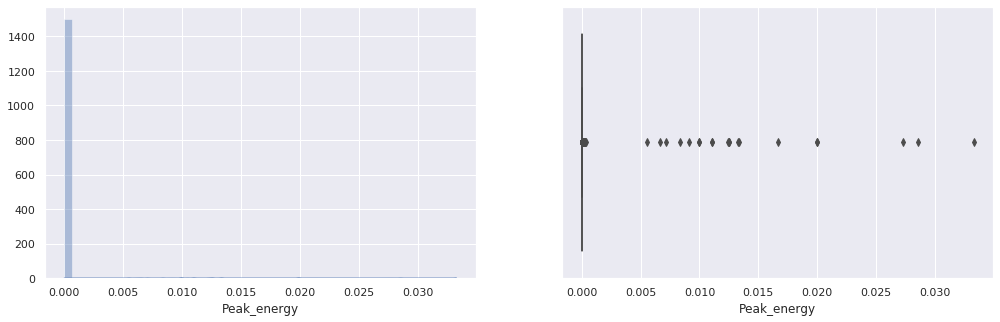

In [49]:
# Peak_energy
sns.set(rc = {'figure.figsize': (17, 5)})
fig, ax = plt.subplots(1, 2)
sns.distplot(df_g['Peak_energy'], ax = ax[0])
sns.boxplot(df_g['Peak_energy'], ax = ax[1])
fig.show()

In [50]:
# Vamos a ver la distribución un poco más en detalle, la dividimos en tramos teniendo en cuenta el mínimo y máximo
cond1 = (df_g['Peak_energy'] >= 1e-9) & (df_g['Peak_energy'] < 1e-8) 
cond2 = (df_g['Peak_energy'] >= 1e-8) & (df_g['Peak_energy'] < 1e-7) 
cond3 = (df_g['Peak_energy'] >= 1e-7) & (df_g['Peak_energy'] < 1e-6) 
cond4 = (df_g['Peak_energy'] >= 1e-6) & (df_g['Peak_energy'] < 1e-5) 
cond5 = (df_g['Peak_energy'] >= 1e-5) & (df_g['Peak_energy'] < 1e-4) 
cond6 = (df_g['Peak_energy'] >= 1e-4) & (df_g['Peak_energy'] < 1e-3) 
cond7 = (df_g['Peak_energy'] >= 1e-3) & (df_g['Peak_energy'] < 1e-2) 
cond8 = (df_g['Peak_energy'] >= 1e-2)  

print(len(df_g[cond1]), len(df_g[cond2]), len(df_g[cond3]), len(df_g[cond4]), len(df_g[cond5]), len(df_g[cond6]),
     len(df_g[cond7]), len(df_g[cond8]))

4 127 2799 2946 335 18 7 13


In [51]:
# Quitamos los valores más altos por arriba
df_g.drop(df_g[df_g['Peak_energy'] > 1e-4].index, inplace = True)

In [52]:
# Y los que más se pierden por abajo
df_g.drop(df_g[df_g['Peak_energy'] < 1e-8].index, inplace = True)

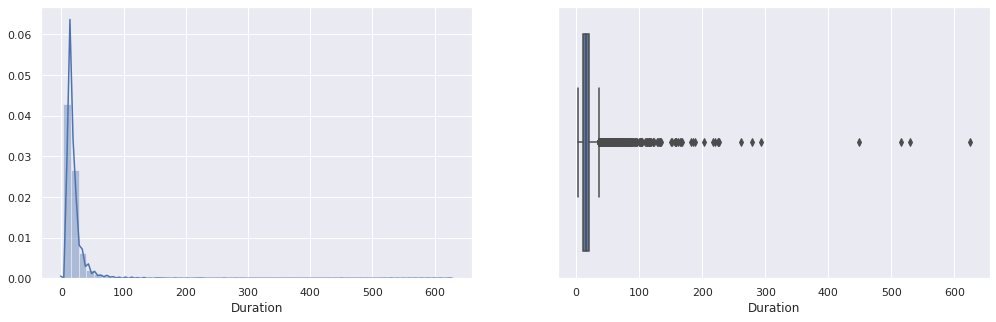

In [53]:
# Duration
sns.set(rc = {'figure.figsize': (17, 5)})
fig, ax = plt.subplots(1, 2)
sns.distplot(df_g['Duration'], ax = ax[0])
sns.boxplot(df_g['Duration'], ax = ax[1])
fig.show()

In [54]:
# Tomamos 250 como valor "prudente" y eliminamos a partir de este
df_g.drop(df_g[df_g['Duration'] > 250].index, inplace = True)

In [55]:
# Guardamos
df_g.to_csv('../../TFM/Datos/Flares_new.csv', index = False)

# CMEs

In [57]:
# Echemos un vistazo al fichero de CMEs
! cat "../../TFM/Datos/univ_all.txt" | head

 ========= SOHO/LASCO CME CATALOG==========      LAST UPDATED: 2020/06/26 18:01
 Date       Time     Central  Width  Linear   2nd order speed      Accel     Mass      Kinetic    MPA   Remarks
                        PA           Speed  initial final   20R                        Energy                 

1996/01/11  00:14:36    267     18    499     571    426      0    -64.3*   -------    -------    272   Only C3
1996/01/13  22:08:30    265     16    290     278    303    372      2.8*   -------    -------    266   Only C3
1996/01/15  07:01:10    262     43    525     600    454      0    -31.1    -------    -------    272   Only C3
1996/01/22  03:11:01    105     37    267     401    130      0   -126.3*   7.1e+13*   2.5e+28*   103   Very Poor Event; Only C3
1996/01/26  09:16:19     90     27    262     254    271    322      1.9*   3.0e+14    1.0e+29     90   Poor Event; Only C3
1996/01/31  06:52:13    274     47    158     219     99      0    -12.3*   2.5e+14*   3.2e+28*   272   Poo

In [58]:
# Con lo que vemos y las descripciones de los campos (ver "univ_all.txt") ya podemos cargar el dataframe
columns = ['Date', 'Time', 'Central_PA', 'Width', 'L_speed', '2_I_speed', '2_F_speed', '2_20R_speed', 'Acceleration',
           'Mass', 'K_energy', 'MPA', 'Remarks']
df = pd.read_fwf('../../TFM/Datos/univ_all.txt', skiprows = 4, header = None, names = columns, index_col = False,
                na_values = [0, '', '--', '---', '----', '-----', '------', '-------', '********', 'Halo'])
# Incluimos 'Halo' en la definición de NaNs puesto que la columna "Central_PA" contiene dichos valores cuando
# "Width" = 360º. Más tarde lidiaremos con ellos
df

,Date,Time,Central_PA,Width,L_speed,2_I_speed,2_F_speed,2_20R_speed,Acceleration,Mass,K_energy,MPA,Remarks
0,1996/01/11,00:14:36,267.0,18,499.0,571.0,426.0,NaN,-64.3*,NaN,NaN,272.0,Only C3
1,1996/01/13,22:08:30,265.0,16,290.0,278.0,303.0,372.0,2.8*,NaN,NaN,266.0,Only C3
2,1996/01/15,07:01:10,262.0,43,525.0,600.0,454.0,NaN,-31.1,NaN,NaN,272.0,Only C3
3,1996/01/22,03:11:01,105.0,37,267.0,401.0,130.0,NaN,-126.3*,7.1e+13*,2.5e+28*,103.0,Very Poor Event; Only C3
4,1996/01/26,09:16:19,90.0,27,262.0,254.0,271.0,322.0,1.9*,3.0e+14,1.0e+29,90.0,Poor Event; Only C3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
30316,2020/05/29,11:24:05,84.0,52,347.0,406.0,288.0,NaN,-21.9*,NaN,NaN,68.0,Poor Event; Only C2
30317,2020/05/29,15:12:05,83.0,46,204.0,215.0,193.0,NaN,-2.8*,NaN,NaN,74.0,Poor Event; Only C2
30318,2020/05/29,17:36:05,76.0,34,210.0,295.0,120.0,NaN,-19.3*,NaN,NaN,73.0,Poor Event; Only C2
30319,2020/05/30,01:25:43,80.0,39,269.0,203.0,339.0,331.0,2.8,NaN,NaN,86.0,NaN


In [59]:
# Un poco de información...
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30321 entries, 0 to 30320
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          30321 non-null  object 
 1   Time          30321 non-null  object 
 2   Central_PA    29551 non-null  float64
 3   Width         30321 non-null  int64  
 4   L_speed       30213 non-null  float64
 5   2_I_speed     28997 non-null  float64
 6   2_F_speed     29756 non-null  float64
 7   2_20R_speed   23256 non-null  float64
 8   Acceleration  29831 non-null  object 
 9   Mass          19738 non-null  object 
 10  K_energy      19706 non-null  object 
 11  MPA           30299 non-null  float64
 12  Remarks       21109 non-null  object 
dtypes: float64(6), int64(1), object(6)
memory usage: 3.0+ MB


In [60]:
# Los campos "Acceleration" y "K_energy" hay que limpiarlos para poder tratarlos
df['Acceleration'] = df['Acceleration'].str.rstrip('*')
df['Acceleration'] = df['Acceleration'].astype(float)
df['K_energy'] = df['K_energy'].str.rstrip('*')
df['K_energy'] = df['K_energy'].astype(float)

In [61]:
# Nuestra columna target será "K_energy", que se calcula a partir de la masa ("Mass") y la velocidad lineal ("L_speed")
# por tanto eliminamos dichas columnas, asi como otras que no nos interesan
df.drop(['Mass', 'L_speed'], axis = 'columns', inplace = True)
df.drop(['Time', 'Remarks'], axis = 'columns', inplace = True)

In [62]:
# Los NaNs en "K_energy" no podemos interpolarlos, pues es la variable objetivo. Con todo el dolor del corazón los eliminamos
df = df.dropna(axis = 0, subset = ['K_energy'])

In [63]:
# Veamos las otras columnas
df.isna().sum()

Date               0
Central_PA       614
Width              0
2_I_speed        803
2_F_speed        134
2_20R_speed     3868
Acceleration      93
K_energy           0
MPA               12
dtype: int64

In [64]:
# Hay bastantes, interpolaremos los valores de las columnas:
df['Central_PA'] = df['Central_PA'].interpolate()
df['2_I_speed'] = df['2_I_speed'].interpolate()
df['2_F_speed'] = df['2_F_speed'].interpolate()
df['2_20R_speed'] = df['2_20R_speed'].interpolate(limit_direction = 'both')
df['Acceleration'] = df['Acceleration'].interpolate()
df['MPA'] = df['MPA'].interpolate()

In [65]:
# Veamos entonces como queda todo
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19706 entries, 3 to 30123
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          19706 non-null  object 
 1   Central_PA    19706 non-null  float64
 2   Width         19706 non-null  int64  
 3   2_I_speed     19706 non-null  float64
 4   2_F_speed     19706 non-null  float64
 5   2_20R_speed   19706 non-null  float64
 6   Acceleration  19706 non-null  float64
 7   K_energy      19706 non-null  float64
 8   MPA           19706 non-null  float64
dtypes: float64(7), int64(1), object(1)
memory usage: 1.5+ MB


In [66]:
# Pasamos la fecha al formato que nos interesa
df['Date'] = pd.to_datetime(df['Date'])

In [67]:
# Agrupamos por fecha, el valor que queremos de cada campo es la media
df_g = df.groupby('Date').mean().reset_index()
df_g

,Date,Central_PA,Width,2_I_speed,2_F_speed,2_20R_speed,Acceleration,K_energy,MPA
0,1996-01-22,105.0,37.0,401.0,130.0,322.000000,-126.30,2.500000e+28,103.0
1,1996-01-26,90.0,27.0,254.0,271.0,322.000000,1.90,1.000000e+29,90.0
2,1996-01-31,274.0,47.0,219.0,99.0,315.500000,-12.30,3.200000e+28,272.0
3,1996-02-03,83.0,52.0,294.0,317.0,309.000000,0.90,8.900000e+29,80.0
4,1996-02-08,263.0,70.0,247.0,126.0,272.500000,-6.00,2.700000e+28,249.0
...,...,...,...,...,...,...,...,...,...
6548,2019-12-24,282.0,57.0,157.0,288.0,615.000000,14.60,1.500000e+28,289.0
6549,2019-12-25,274.0,49.0,337.0,245.0,1088.666667,-14.30,1.300000e+28,268.0
6550,2019-12-26,99.0,58.0,196.0,104.0,1562.333333,-11.10,9.200000e+27,109.0
6551,2019-12-27,293.0,33.5,275.0,592.0,1086.000000,81.05,3.550000e+28,292.5


In [68]:
# Comprobamos la estadística
df_g.describe()

,Central_PA,Width,2_I_speed,2_F_speed,2_20R_speed,Acceleration,K_energy,MPA
count,6553.000000,6553.000000,6553.000000,6553.000000,6553.000000,6553.000000,6.553000e+03,6553.000000
mean,180.108358,69.490918,358.738062,394.005208,529.656222,2.241041,5.627735e+30,180.294766
std,71.920116,47.728418,231.478827,203.495362,258.452161,20.663508,6.421144e+31,72.384148
min,1.000000,11.000000,2.000000,9.000000,21.000000,-232.000000,5.500000e+24,1.000000
25%,121.000000,40.000000,209.600000,265.500000,365.000000,-3.800000,6.700000e+28,120.600000
50%,181.166667,57.000000,313.000000,362.142857,487.000000,1.850000,3.855000e+29,181.250000
75%,239.000000,82.000000,452.875000,478.600000,635.166667,7.160000,1.968700e+30,239.333333
max,359.000000,360.000000,3703.000000,2558.000000,3294.000000,446.100000,4.200000e+33,359.000000


Vamos con los outliers, para decidir cuales quitar usaremos gráficas de distribución así como los valores de 
media y desviación estándar

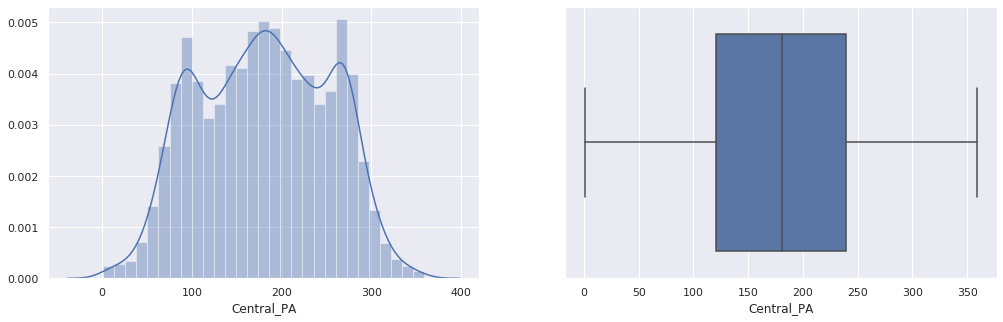

In [69]:
# Central_PA
sns.set(rc = {'figure.figsize': (17, 5)})
fig, ax = plt.subplots(1, 2)
sns.distplot(df_g['Central_PA'], ax = ax[0])
sns.boxplot(df_g['Central_PA'], ax = ax[1])
fig.show()
# No quitaremos ningún valor para esta columna

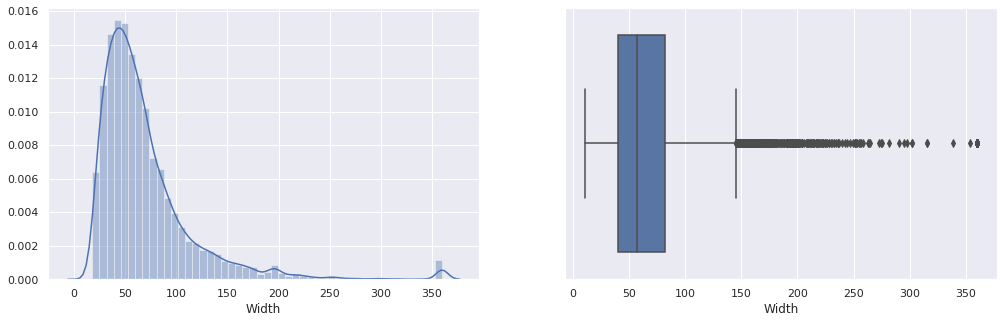

In [70]:
# Width
sns.set(rc = {'figure.figsize': (17, 5)})
fig, ax = plt.subplots(1, 2)
sns.distplot(df_g['Width'], ax = ax[0])
sns.boxplot(df_g['Width'], ax = ax[1])
fig.show()
# No quitaremos ningún valor para esta columna

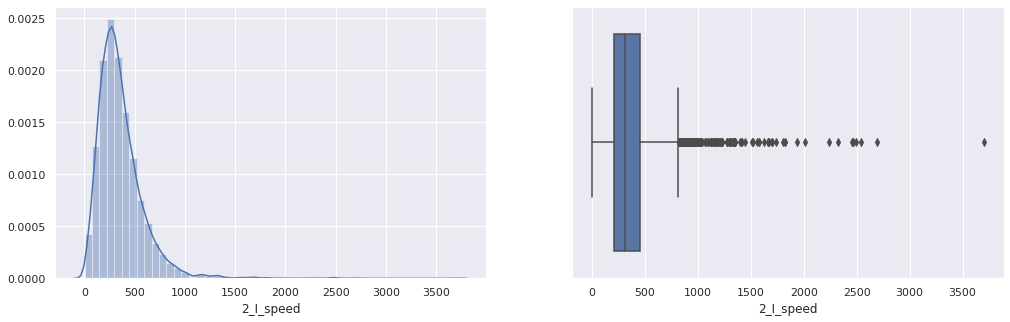

In [71]:
# 2_I_speed
sns.set(rc = {'figure.figsize': (17, 5)})
fig, ax = plt.subplots(1, 2)
sns.distplot(df_g['2_I_speed'], ax = ax[0])
sns.boxplot(df_g['2_I_speed'], ax = ax[1])
fig.show()

In [72]:
# Teniendo en cuenta lo que hemos dicho
df_g.drop(df_g[df_g['2_I_speed'] >= 1500].index, inplace = True)

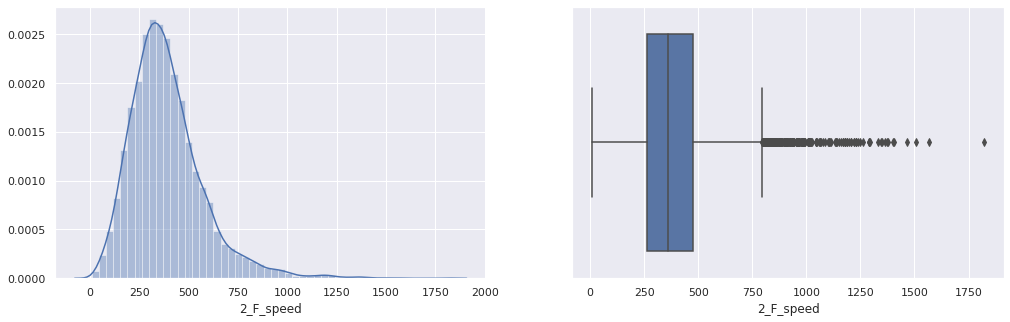

In [73]:
# 2_F_speed
sns.set(rc = {'figure.figsize': (17, 5)})
fig, ax = plt.subplots(1, 2)
sns.distplot(df_g['2_F_speed'], ax = ax[0])
sns.boxplot(df_g['2_F_speed'], ax = ax[1])
fig.show()

In [74]:
df_g.drop(df_g[df_g['2_F_speed'] >= 1250].index, inplace = True)

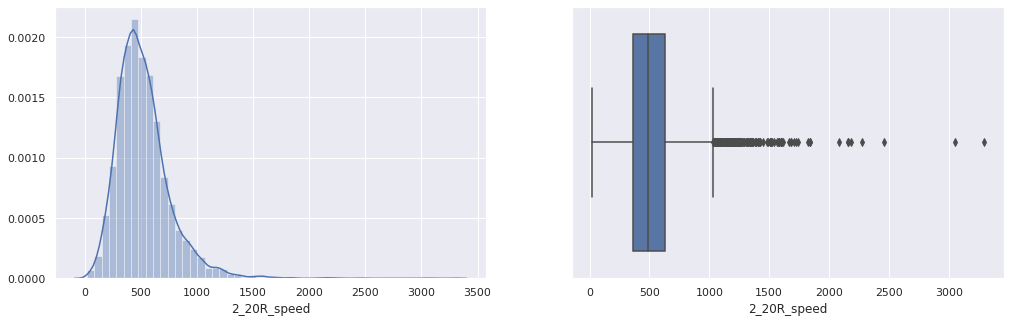

In [75]:
# 2_20R_speed
sns.set(rc = {'figure.figsize': (17, 5)})
fig, ax = plt.subplots(1, 2)
sns.distplot(df_g['2_20R_speed'], ax = ax[0])
sns.boxplot(df_g['2_20R_speed'], ax = ax[1])
fig.show()

In [76]:
df_g.drop(df_g[df_g['2_20R_speed'] >= 2000].index, inplace = True)

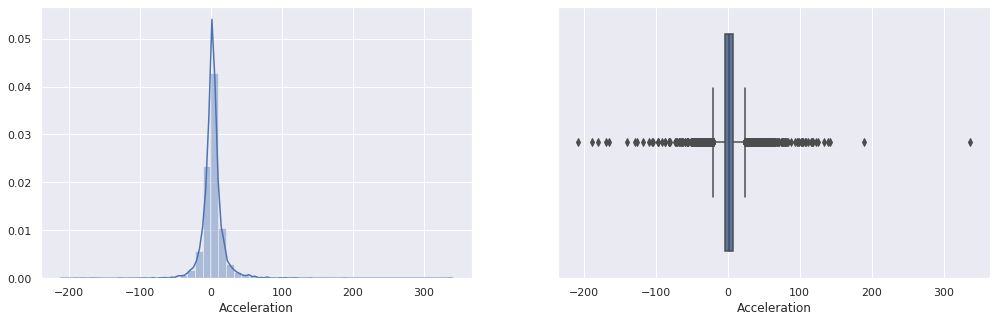

In [77]:
# Acceleration
sns.set(rc = {'figure.figsize': (17, 5)})
fig, ax = plt.subplots(1, 2)
sns.distplot(df_g['Acceleration'], ax = ax[0])
sns.boxplot(df_g['Acceleration'], ax = ax[1])
fig.show()

In [78]:
# La columna "Acceleration" es difícil por su distribución y porque se nos dice que son valores poco fiables...
df_g.drop(df_g[df_g['Acceleration'] > 150].index, inplace = True)
df_g.drop(df_g[df_g['Acceleration'] < -150].index, inplace = True)

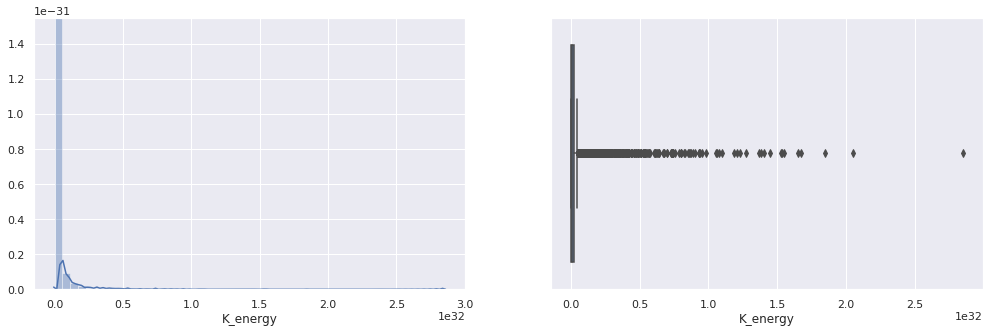

In [79]:
# K_energy
sns.set(rc = {'figure.figsize': (17, 5)})
fig, ax = plt.subplots(1, 2)
sns.distplot(df_g['K_energy'], ax = ax[0])
sns.boxplot(df_g['K_energy'], ax = ax[1])
fig.show()

In [80]:
# Vamos a ver la distribución más en detalle, tomando intervalos lógicos entre el mínimo y el máximo
cond1 = (df_g['K_energy'] >= 1e+24) & (df_g['K_energy'] < 1e+25) 
cond2 = (df_g['K_energy'] >= 1e+25) & (df_g['K_energy'] < 1e+26) 
cond3 = (df_g['K_energy'] >= 1e+26) & (df_g['K_energy'] < 1e+27)
cond4 = (df_g['K_energy'] >= 1e+27) & (df_g['K_energy'] < 1e+28) 
cond5 = (df_g['K_energy'] >= 1e+28) & (df_g['K_energy'] < 1e+29) 
cond6 = (df_g['K_energy'] >= 1e+29) & (df_g['K_energy'] < 1e+30)
cond7 = (df_g['K_energy'] >= 1e+30) & (df_g['K_energy'] < 1e+31) 
cond8 = (df_g['K_energy'] >= 1e+31) & (df_g['K_energy'] < 1e+32) 
cond9 = (df_g['K_energy'] >= 1e+32) 

print(len(df_g[cond1]), len(df_g[cond2]), len(df_g[cond3]), len(df_g[cond4]), len(df_g[cond5]), len(df_g[cond6]), 
len(df_g[cond7]), len(df_g[cond8]), len(df_g[cond9]))

1 9 79 467 1423 2228 1818 450 20


In [81]:
# Eliminaremos los correspondientes a los tramos 1, 2 y 9
df_g.drop(df_g[cond1].index, inplace =True)
df_g.drop(df_g[cond2].index, inplace =True)
df_g.drop(df_g[cond9].index, inplace =True)

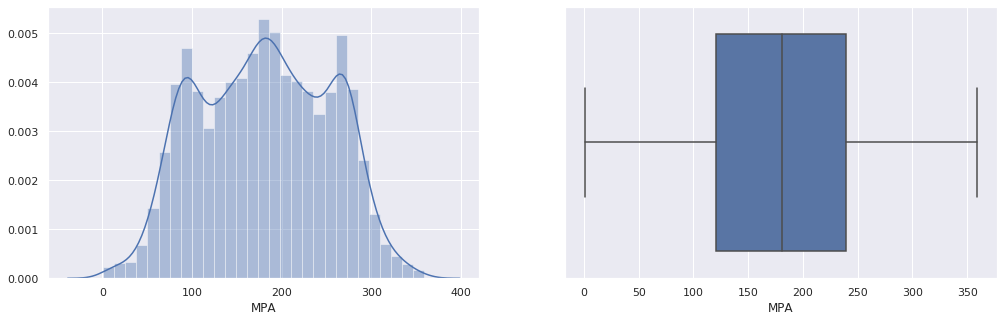

In [82]:
# MPA
sns.set(rc = {'figure.figsize': (17, 5)})
fig, ax = plt.subplots(1, 2)
sns.distplot(df_g['MPA'], ax = ax[0])
sns.boxplot(df_g['MPA'], ax = ax[1])
fig.show()
# No quitaremos ningún valor para esta columna

En realidad lo que nos interesa no es predecir el valor exacto de K_energy, sino el "rango". 
Para facilitar las cosas vamos a discretizar la variable en una serie de tramos

In [83]:
# Definimos una función para clasificar los valores, asignaremos números del 1 al 6 según la intensidad de K_energy
def Classifier(value):
    result = 0
    if (value >= 1e+26) and (value < 1e+27):
        result = 1
    elif (value >= 1e+27) and (value < 1e+28):
        result = 2
    elif (value >= 1e+28) and (value < 1e+29):
        result = 3
    elif (value >= 1e+29) and (value < 1e+30):
        result = 4
    elif (value >= 1e+30) and (value < 1e+31):
        result = 5
    elif (value >= 1e+31):
        result = 6
    
    return result    

In [84]:
# Creamos una nueva columna con dicha clasificación
df_g['Class'] = df_g['K_energy'].apply(Classifier)

In [85]:
# Ya no necesitamos K_energy
df_g.drop(['K_energy'], axis = 'columns', inplace = True)

In [86]:
df_g

,Date,Central_PA,Width,2_I_speed,2_F_speed,2_20R_speed,Acceleration,MPA,Class
0,1996-01-22,105.0,37.0,401.0,130.0,322.000000,-126.30,103.0,3
1,1996-01-26,90.0,27.0,254.0,271.0,322.000000,1.90,90.0,4
2,1996-01-31,274.0,47.0,219.0,99.0,315.500000,-12.30,272.0,3
3,1996-02-03,83.0,52.0,294.0,317.0,309.000000,0.90,80.0,4
4,1996-02-08,263.0,70.0,247.0,126.0,272.500000,-6.00,249.0,3
...,...,...,...,...,...,...,...,...,...
6548,2019-12-24,282.0,57.0,157.0,288.0,615.000000,14.60,289.0,3
6549,2019-12-25,274.0,49.0,337.0,245.0,1088.666667,-14.30,268.0,3
6550,2019-12-26,99.0,58.0,196.0,104.0,1562.333333,-11.10,109.0,2
6551,2019-12-27,293.0,33.5,275.0,592.0,1086.000000,81.05,292.5,3


In [87]:
# Guardamos
df_g.to_csv('../../TFM/Datos/CMEs_new.csv', index = False)

# Unimos los tres dataframes

In [88]:
# Cargamos Spots
Spots = pd.read_csv('../../TFM/Datos/Spots_new.csv', sep = ',')

In [89]:
# Cargamos Flares
Flares = pd.read_csv('../../TFM/Datos/Flares_new.csv', sep = ',')

In [90]:
# Cargamos CMEs
CMEs = pd.read_csv('../../TFM/Datos/CMEs_new.csv', sep = ',')

In [91]:
# Haremos un inner-join por la columna "Date"
Spots_Flares = pd.merge(left = Spots, right = Flares, left_on = 'Date', right_on = 'Date')

In [92]:
# Haremos otro inner-join también por la columna "Date"
Spots_Flares_CMEs = pd.merge(left = Spots_Flares, right = CMEs, left_on = 'Date', right_on = 'Date')
Spots_Flares_CMEs

,index,Date,Spots,Duration,Peak_energy,Central_PA,Width,2_I_speed,2_F_speed,2_20R_speed,Acceleration,MPA,Class
0,65043,1996-01-31,13.000000,10.000000,1.860000e-07,274.000000,47.0,219.00,99.000000,315.500000,-12.30,272.0,3
1,65083,1996-03-11,22.000000,12.111111,5.227778e-07,86.000000,52.0,124.00,352.000000,656.000000,20.10,77.0,4
2,65086,1996-03-14,18.000000,6.000000,1.600000e-07,285.000000,59.0,526.00,307.000000,302.000000,-8.90,292.0,5
3,65138,1996-05-05,14.666667,43.444444,1.462222e-06,93.000000,62.5,373.75,370.000000,370.000000,0.05,78.5,5
4,65139,1996-05-06,15.000000,24.666667,7.800000e-07,88.000000,73.0,496.00,360.000000,404.000000,-5.00,83.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4289,72678,2016-12-26,16.000000,14.000000,4.375000e-07,72.000000,25.0,127.00,114.000000,341.000000,-1.90,71.0,2
4290,72679,2016-12-27,16.000000,20.333333,2.066667e-07,236.000000,33.0,79.00,284.000000,430.000000,7.50,239.0,3
4291,72681,2016-12-29,11.000000,9.000000,1.300000e-07,48.000000,20.0,112.00,180.000000,370.000000,5.60,55.0,2
4292,72682,2016-12-30,11.000000,11.500000,1.600000e-07,136.000000,34.5,250.00,419.000000,518.500000,9.50,143.5,4


In [93]:
# Eliminamos la columna "index"
Spots_Flares_CMEs.drop(['index'], axis = 'columns', inplace = True)

In [94]:
# Guardamos el dataframe final
Spots_Flares_CMEs.to_csv('../../TFM/Datos/SFC.csv', index = False)